In [191]:
from collections import defaultdict
from functools import lru_cachefi
import random
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statbotics

%matplotlib notebook

sb = statbotics.Statbotics()

In [10]:
all_teams = sb.get_team_years(year=2023, limit=10000)
all_teams_dict = {t["team"]: t for t in all_teams}
len(all_teams)

3286

In [6]:
champ_teams = sb.get_team_events(event="2023cmptx", limit=10000)
champ_team_nums = [t["team"] for t in champ_teams]
champ_team_nums += [333, 449, 999, 2170, 2337, 4779, 4976, 5123, 7174, 7534, 8013, 9152, 9244]

print(len(set(champ_team_nums)))

620


In [409]:
epa_breakdown = pd.read_json("https://raw.githubusercontent.com/avgupta456/statbotics/master/data/2023/epa_breakdown.json", orient="index")


In [417]:
team_to_epa = {t: all_teams_dict[t]["epa_end"] for t in champ_team_nums}
team_to_rp_1_epa = {t: all_teams_dict[t]["rp_1_epa_end"] for t in champ_team_nums}
team_to_rp_2_epa = {t: all_teams_dict[t]["rp_2_epa_end"] for t in champ_team_nums}
team_to_cycles = {t: epa_breakdown.loc[t]["total_cycles"] for t in champ_team_nums}

print(team_to_epa[2056], team_to_rp_1_epa[2056], team_to_rp_2_epa[2056], team_to_cycles[2056])
print(team_to_epa[254], team_to_rp_1_epa[254], team_to_rp_2_epa[254], team_to_cycles[254])

84.85 0.9931 0.5175 12.2601407515
80.19 0.9545 0.6071 11.6093456675


In [52]:
TOTAL_MEAN = 74.57
TOTAL_SD = 29.36

In [33]:
@lru_cache
def make_request(url):
    response = requests.get(url)
    response.raise_for_status()
    data = response.text
    lines = data.split("\n")
    return lines

@lru_cache
def get_schedule(num_teams: int, num_matches: int):
    # TODO: remove this once we have pre-generated schedules for 100+ teams
    if num_teams > 100:
        schedule1 = get_schedule(100, num_matches)
        schedule2 = get_schedule(num_teams - 100, num_matches)
        schedule2 = [
            {"red": [team + 100 for team in match["red"]], "blue": [team + 100 for team in match["blue"]]}
            for match in schedule2
        ]
        return schedule1 + schedule2

    # load csv from external URL using requests
    lines = make_request(f"https://raw.githubusercontent.com/Team254/cheesy-arena/main/schedules/{num_teams}_{num_matches}.csv")
    
    schedule = []
    for line in lines:
        match = line.split(",")
        if len(match) < 12:
            continue
        red = [int(match[0]), int(match[2]), int(match[4])]
        blue = [int(match[6]), int(match[8]), int(match[10])]
        schedule.append({"red": red, "blue": blue})
        
    return schedule

In [422]:
def get_win_prob(a, b):
    return 1 / (1 + 10 ** (((-5 / 8) * (a - b)) / TOTAL_SD))

def get_rp_pred(a):
    return 1 / (1 + np.e ** (-4 * (a - 0.5)))

def sim_single_quals(teams, schedule):
    scores, grids = [], []
    curr_sim_matches = {t: 0 for t in teams}
    curr_sim_rps = {t: 0 for t in teams}
    for m in schedule:
        red_epa = sum(team_to_epa[x] for x in m["red"])
        blue_epa = sum(team_to_epa[x] for x in m["blue"])
        red_rp_1_epa = sum(team_to_rp_1_epa[x] for x in m["red"])
        blue_rp_1_epa = sum(team_to_rp_1_epa[x] for x in m["blue"])
        red_rp_2_epa = sum(team_to_rp_2_epa[x] for x in m["red"])
        blue_rp_2_epa = sum(team_to_rp_2_epa[x] for x in m["blue"])
        red_cycles = sum(team_to_cycles[x] for x in m["red"])
        blue_cycles = sum(team_to_cycles[x] for x in m["blue"])
        
        scores.extend([red_epa, blue_epa])
        grids.extend([red_cycles, blue_cycles])
        
        win_prob = get_win_prob(red_epa, blue_epa)
        red_win = 1 if random.random() < win_prob else 0

        red_rp_1_prob = get_rp_pred(0.9 * red_rp_1_epa)
        red_rp_1 = 1 if random.random() < red_rp_1_prob else 0
        
        red_rp_2_prob = get_rp_pred(red_rp_2_epa)
        red_rp_2 = 1 if random.random() < red_rp_2_prob else 0
        
        blue_rp_1_prob = get_rp_pred(0.9 * blue_rp_1_epa)
        blue_rp_1 = 1 if random.random() < blue_rp_1_prob else 0
        
        blue_rp_2_prob = get_rp_pred(blue_rp_2_epa)
        blue_rp_2 = 1 if random.random() < blue_rp_2_prob else 0

        red_rps = red_rp_1 + red_rp_2 + (2 if red_win else 0)
        blue_rps = blue_rp_1 + blue_rp_2 + (0 if red_win else 2)
        
        for x in m["red"]:
            curr_sim_matches[x] += 1
            if curr_sim_matches[x] <= 10:
                curr_sim_rps[x] += red_rps
            
        for x in m["blue"]:
            curr_sim_matches[x] += 1
            if curr_sim_matches[x] <= 10:
                curr_sim_rps[x] += blue_rps
            
    curr_sim_ranks = sorted(curr_sim_rps.items(), key=lambda x: [-x[1], random.random()])
    
    return [x[0] for x in curr_sim_ranks], scores, grids

def softmax_select(options, mult=1):
    exp = [np.e ** (mult * o) for o in options]
    sum_exp = sum(exp)
    exp = [e / sum_exp for e in exp]
    rand = random.random()
    curr, i = 0, 0
    while curr < rand:
        curr += exp[i]
        i += 1
    return i - 1

def sim_alliance_selection(ranks):
    alliances = [[], [], [], [], [], [], [], []]
    locked_teams = []
    remaining_teams = [(r, team_to_epa[r]) for r in ranks]
    
    r1_mult = 1 / 3
    r2_mult = 1 / 2
    
    def handle_selection(selector, reject=True):
        selected = None
        while selected is None:
            temp_remaining_teams = [r for r in remaining_teams if r not in locked_teams]
            _selected = softmax_select([r[1] for r in temp_remaining_teams], r1_mult)
            _selected_team = temp_remaining_teams[_selected]
            orig_rank = ranks.index(_selected_team[0]) + 1
            if not reject or orig_rank > 8:
                selected = _selected
                continue
                
            selected_rank = remaining_teams.index(_selected_team) + 1
            remaining_best_epas = sorted(temp_remaining_teams[_selected + 1:], key=lambda x: -x[1])
            if remaining_best_epas[selected_rank][1] > selector[1] + 5:
                locked_teams.append(_selected_team)
            else:
                selected = _selected
                
        return remaining_teams.index(temp_remaining_teams[selected])
    
    # Captain and Round 1
    alliances[0].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[0].append(remaining_teams.pop(selected))
    
    alliances[1].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[1].append(remaining_teams.pop(selected))
    
    alliances[2].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[2].append(remaining_teams.pop(selected))
    
    alliances[3].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[3].append(remaining_teams.pop(selected))

    alliances[4].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[4].append(remaining_teams.pop(selected))
    
    alliances[5].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[5].append(remaining_teams.pop(selected))
    
    alliances[6].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[6].append(remaining_teams.pop(selected))
    
    alliances[7].append(remaining_teams.pop(0))
    selected = handle_selection(alliances[0][0])
    alliances[7].append(remaining_teams.pop(selected))
    
    # Round 2
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[7].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[6].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[5].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[4].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[3].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[2].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[1].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[0].append(remaining_teams.pop(selected))
    
    # Round 3
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[0].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[1].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[2].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[3].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[4].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[5].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[6].append(remaining_teams.pop(selected))
    selected = softmax_select([r[1] for r in remaining_teams], r2_mult)
    alliances[7].append(remaining_teams.pop(selected))
    
    aepas = [sum(a[1] for a in alliance[:3]) for alliance in alliances]
    return [[a[0] for a in alliance] for alliance in alliances], aepas

def sim_single_elims(alliances):
    scores, grids = [], []
    
    aepas = [sum(team_to_epa[a] for a in alliance[:3]) for alliance in alliances]
    ms = [[0, 7], [3, 4], [1, 6], [2, 5], [], [], [], [], [], [], [], [], []]
    
    def _get_win_prob(i):
        red_cycles = sum(team_to_cycles[x] for x in alliances[ms[i][0]][:3])
        blue_cycles = sum(team_to_cycles[x] for x in alliances[ms[i][1]][:3])
        
        scores.extend([aepas[ms[i][0]], aepas[ms[i][1]]])
        grids.extend([red_cycles, blue_cycles])
        return get_win_prob(aepas[ms[i][0]], aepas[ms[i][1]])

    m1_red_winner = random.random() < _get_win_prob(0)
    ms[4].append(ms[0][1] if m1_red_winner else ms[0][0])
    ms[6].append(ms[0][0] if m1_red_winner else ms[0][1])
    
    m2_red_winner = random.random() < _get_win_prob(1)
    ms[4].append(ms[1][1] if m2_red_winner else ms[1][0])
    ms[6].append(ms[1][0] if m2_red_winner else ms[1][1])
    
    m3_red_winner = random.random() < _get_win_prob(2)
    ms[5].append(ms[2][1] if m3_red_winner else ms[2][0])
    ms[7].append(ms[2][0] if m3_red_winner else ms[2][1])
    
    m4_red_winner = random.random() < _get_win_prob(3)
    ms[5].append(ms[3][1] if m4_red_winner else ms[3][0])
    ms[7].append(ms[3][0] if m4_red_winner else ms[3][1])
    
    m5_red_winner = random.random() < _get_win_prob(4)
    ms[9].append(ms[4][0] if m5_red_winner else ms[4][1])
    
    m6_red_winner = random.random() < _get_win_prob(5)
    ms[8].append(ms[5][0] if m6_red_winner else ms[5][1])
    
    m7_red_winner = random.random() < _get_win_prob(6)
    ms[8].append(ms[6][1] if m7_red_winner else ms[6][0])
    ms[10].append(ms[6][0] if m7_red_winner else ms[6][1])
    
    m8_red_winner = random.random() < _get_win_prob(7)
    ms[9].append(ms[7][1] if m8_red_winner else ms[7][0])
    ms[10].append(ms[7][0] if m8_red_winner else ms[7][1])
    
    m9_red_winner = random.random() < _get_win_prob(8)
    ms[11].append(ms[8][0] if m9_red_winner else ms[8][1])
    
    m10_red_winner = random.random() < _get_win_prob(9)
    ms[11].append(ms[9][0] if m10_red_winner else ms[9][1])
    
    m11_red_winner = random.random() < _get_win_prob(10)
    ms[12].append(ms[10][1] if m11_red_winner else ms[10][0])
    finalist_1 = ms[10][0] if m11_red_winner else ms[10][1]
    
    m12_red_winner = random.random() < _get_win_prob(11)
    fourth_place = ms[11][1] if m12_red_winner else ms[11][0]
    ms[12].append(ms[11][0] if m12_red_winner else ms[11][1])
    
    m13_red_winner = random.random() < _get_win_prob(12)
    third_place = ms[12][1] if m13_red_winner else ms[12][0]
    finalist_2 = ms[12][0] if m13_red_winner else ms[12][1]
    
    
    f1_red_winner = random.random() < get_win_prob(aepas[finalist_1], aepas[finalist_2])
    f2_red_winner = random.random() < get_win_prob(aepas[finalist_1], aepas[finalist_2])
    f3_red_winner = random.random() < get_win_prob(aepas[finalist_1], aepas[finalist_2])
    winner = finalist_1 if f1_red_winner + f2_red_winner + f3_red_winner >= 2 else finalist_2
    second_place = finalist_2 if winner == finalist_1 else finalist_1
    
    return winner, second_place, third_place, fourth_place, scores, grids


In [423]:
overall_winner_count = defaultdict(int)
overall_finalist_count = defaultdict(int)
overall_third_place_count = defaultdict(int)
overall_fourth_place_count = defaultdict(int)

winner_count = defaultdict(int)
finalist_count = defaultdict(int)
third_place_count = defaultdict(int)
fourth_place_count = defaultdict(int)

winner_alliances = defaultdict(int)
winner_best_epas = []
alliance_epas = []
best_epas = []
winner_epas = []

einstein_winner_best_epas = []
einstein_alliance_epas = []
einstein_best_epas = []
einstein_winner_epas = []

quals_score_distrib = []
quals_grid_distrib = []

elims_score_distrib = []
elims_grid_distrib = []

einstein_score_distrib = []
einstein_grid_distrib = []

qual_rank_list = defaultdict(lambda: [0] * 78)

num_sims = 1000

def pre_sim(all_teams):
    for sim in range(num_sims):
        if sim % 100 == 0:
            print(sim)
            
        random.shuffle(all_teams)

        division_1 = all_teams[:78]
        division_2 = all_teams[78:156]
        division_3 = all_teams[156:233]
        division_4 = all_teams[233:310]
        division_5 = all_teams[310:388]
        division_6 = all_teams[388:466]
        division_7 = all_teams[466:543]
        division_8 = all_teams[543:620]

        divisions = [division_1, division_2, division_3, division_4, division_5, division_6, division_7, division_8]

        einstein_alliances = []
        einstein_aepas = []
        for division in divisions:
            random.shuffle(division)
            schedule = get_schedule(len(division), 10)
            schedule = [
                {
                    "red": [division[x - 1] for x in m["red"]],
                    "blue": [division[x - 1] for x in m["blue"]],
                }
                for m in schedule
            ]
            qual_ranks, qual_scores, qual_grids = sim_single_quals(division, schedule)
            for i, t in enumerate(qual_ranks):
                qual_rank_list[t][i] += 1
                
            quals_score_distrib.extend(qual_scores)
            quals_grid_distrib.extend(qual_grids)
            
            alliances, aepas = sim_alliance_selection(qual_ranks)
            winner, finalist, third_place, fourth_place, elim_scores, elim_grids = sim_single_elims(alliances)
            einstein_alliances.append(alliances[winner])
            einstein_aepas.append(aepas[winner])
            
            elims_score_distrib.extend(elim_scores)
            elims_grid_distrib.extend(elim_grids)
            
            winner_alliances[winner] += 1
            best_epa = max(aepas)
            winner_epa = aepas[winner]
            winner_best_epas.append(best_epa == winner_epa)
            alliance_epas.extend(aepas)
            best_epas.append(best_epa)
            winner_epas.append(winner_epa)
            
            for t in alliances[winner]:
                winner_count[t] += 1
                
            for t in alliances[finalist]:
                finalist_count[t] += 1
                
            for t in alliances[third_place]:
                third_place_count[t] += 1
                
            for t in alliances[fourth_place]:
                fourth_place_count[t] += 1
            
        winner, finalist, third_place, fourth_place, einstein_scores, einstein_grids = sim_single_elims(einstein_alliances)

        einstein_score_distrib.extend(einstein_scores)
        einstein_grid_distrib.extend(einstein_grids)
        
        einstein_best_epa = max(einstein_aepas)
        einstein_winner_epa = einstein_aepas[winner]
        einstein_winner_best_epas.append(einstein_best_epa == einstein_winner_epa)
        einstein_alliance_epas.extend(einstein_aepas)
        einstein_best_epas.append(einstein_best_epa)
        einstein_winner_epas.append(einstein_winner_epa)

        for t in einstein_alliances[winner]:
            overall_winner_count[t] += 1
            
        for t in einstein_alliances[finalist]:
            overall_finalist_count[t] += 1
            
        for t in einstein_alliances[third_place]:
            overall_third_place_count[t] += 1
            
        for t in einstein_alliances[fourth_place]:
            overall_fourth_place_count[t] += 1
            
pre_sim(champ_team_nums)

0
100
200
300
400
500
600
700
800
900


In [424]:
def pad(s, length = 15):
    return s + "&nbsp;" * (length - len(s))

print("Division")
print("| Rank | ", pad("Team"), " | ", pad("Winner"), " | ", pad("Finalist"), " | ", pad("3rd Place"), " | ", pad("4th Place"), " |")
print("| ---- | ---- | --- | --- | --- | --- |")
for i, (key, count) in enumerate(sorted(winner_count.items(), key=lambda x: -x[1])[:25]):
    print("|", i + 1, "|", key, "|", str(round(100 * winner_count[key] / num_sims, 1)) + "%", "|", str(round(100 * finalist_count[key] / num_sims, 1)) + "%", "|", str(round(100 * third_place_count[key] / num_sims, 1)) + "%", "|", str(round(100 * fourth_place_count[key] / num_sims, 1)) + "%", "|")
print()

print("Division")
print("| Rank | ", pad("Team"), " | ", pad("Winner"), " | ", pad("Finalist"), " | ", pad("3rd Place"), " | ", pad("4th Place"), " |")
print("| ---- | ---- | --- | --- | --- | --- |")
for i, (key, count) in enumerate(sorted(winner_count.items(), key=lambda x: -x[1])[:100]):
    print("|", i + 1, "|", key, "|", str(round(100 * winner_count[key] / num_sims, 1)) + "%", "|", str(round(100 * finalist_count[key] / num_sims, 1)) + "%", "|", str(round(100 * third_place_count[key] / num_sims, 1)) + "%", "|", str(round(100 * fourth_place_count[key] / num_sims, 1)) + "%", "|")
print()

print("Einstein")
print("| Rank | ", pad("Team"), " | ", pad("Winner"), " | ", pad("Finalist"), " | ", pad("3rd Place"), " | ", pad("4th Place"), " |")
print("| ---- | ---- | --- | --- | --- | --- |")
for i, (key, count) in enumerate(sorted(overall_winner_count.items(), key=lambda x: -x[1])[:25]):
    print("|", i + 1, "|", key, "|", str(round(100 * overall_winner_count[key] / num_sims, 1)) + "%", "|", str(round(100 * overall_finalist_count[key] / num_sims, 1)) + "%", "|", str(round(100 * overall_third_place_count[key] / num_sims, 1)) + "%", "|", str(round(100 * overall_fourth_place_count[key] / num_sims, 1)) + "%", "|")
print()

print("Einstein")
print("| Rank | ", pad("Team"), " | ", pad("Winner"), " | ", pad("Finalist"), " | ", pad("3rd Place"), " | ", pad("4th Place"), " |")
print("| ---- | ---- | --- | --- | --- | --- |")
for i, (key, count) in enumerate(sorted(overall_winner_count.items(), key=lambda x: -x[1])[:100]):
    print("|", i + 1, "|", key, "|", str(round(100 * overall_winner_count[key] / num_sims, 1)) + "%", "|", str(round(100 * overall_finalist_count[key] / num_sims, 1)) + "%", "|", str(round(100 * overall_third_place_count[key] / num_sims, 1)) + "%", "|", str(round(100 * overall_fourth_place_count[key] / num_sims, 1)) + "%", "|")
print()

print("| Alliance | Win Probability |")
print("| --- | --- |")
for i, count in sorted(winner_alliances.items(), key=lambda x: -x[1]):
    print("|", i + 1, "|", str(round(100 * count / 8 / num_sims, 2)) + "%", "|")
print()

print("Probability 'Favorite' Wins:", round(np.array(winner_best_epas).mean(), 4))
print("Average Division Alliance EPA:", round(np.array(alliance_epas).mean(), 1))
print("Average Division 'Favorite' EPA:", round(np.array(best_epas).mean(), 1))
print("Average Division Winner EPA:", round(np.array(winner_epas).mean(), 1))
print()

print("Probability Einstein 'Favorite' Wins:", round(np.array(einstein_winner_best_epas).mean(), 4))
print("Average Einstein Alliance EPA:", round(np.array(einstein_alliance_epas).mean(), 1))
print("Average Einstein 'Favorite' EPA:", round(np.array(einstein_best_epas).mean(), 1))
print("Average Einstein Winner EPA:", round(np.array(einstein_winner_epas).mean(), 1))
print()

Division
| Rank |  Team&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  Winner&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  Finalist&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  3rd Place&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  4th Place&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |
| ---- | ---- | --- | --- | --- | --- |
| 1 | 2056 | 68.3% | 10.1% | 6.6% | 4.8% |
| 2 | 1323 | 59.6% | 11.0% | 9.8% | 6.5% |
| 3 | 254 | 54.9% | 15.0% | 9.5% | 7.1% |
| 4 | 1678 | 41.5% | 17.5% | 10.3% | 10.0% |
| 5 | 3005 | 37.5% | 17.7% | 10.5% | 10.2% |
| 6 | 5940 | 33.5% | 14.5% | 13.4% | 9.3% |
| 7 | 111 | 32.8% | 17.8% | 12.8% | 9.1% |
| 8 | 971 | 32.5% | 18.2% | 12.7% | 10.7% |
| 9 | 3538 | 30.2% | 18.3% | 14.4% | 10.3% |
| 10 | 6036 | 28.6% | 18.1% | 12.8% | 10.8% |
| 11 | 930 | 25.8% | 16.9% | 14.6% | 10.8% |
| 12 | 6672 | 24.7% | 14.9% | 16.4% | 12.3% |
| 13 | 7157 | 23.9% | 16.4% | 13.7% | 12.6% |
| 14 | 195 | 20.4% | 15.8% | 15.3% | 13.0% |
| 15 | 1987 | 20.3% | 15.

In [425]:
avg_ranks = {t: sum(((i + 1) * qual_rank_list[t][i]) for i in range(78)) / num_sims for t in qual_rank_list}
top_1 = {t: sum(qual_rank_list[t][i] for i in range(1)) / num_sims for t in qual_rank_list}
top_4 = {t: sum(qual_rank_list[t][i] for i in range(4)) / num_sims for t in qual_rank_list}
top_8 = {t: sum(qual_rank_list[t][i] for i in range(8)) / num_sims for t in qual_rank_list}
top_16 = {t: sum(qual_rank_list[t][i] for i in range(16)) / num_sims for t in qual_rank_list}

print("| Rank | ", pad("Team"), " | ", pad("Mean Rank"), " | ", pad("1st"), " | ", pad("Top 4"), " | ", pad("Top 8"), " | ", pad("Top 16"), " |")
print("| --- | --- | --- | --- | --- | --- | --- |")
for i, (key, avg_rank) in enumerate(sorted(avg_ranks.items(), key=lambda x: x[1])[:25]):
    print("|", i + 1, "|", key, "|", round(avg_rank, 2), "|", str(round(100 * top_1[key], 1)) + "%", "|", str(round(100 * top_4[key], 1)) + "%", "|", str(round(100 * top_8[key], 1)) + "%", "|", str(round(100 * top_16[key], 1)) + "%", "|")
print()
    
print("| Rank | ", pad("Team"), " | ", pad("Mean Rank"), " | ", pad("1st"), " | ", pad("Top 4"), " | ", pad("Top 8"), " | ", pad("Top 16"), " |")
print("| --- | --- | --- | --- | --- | --- | --- |")
for i, (key, avg_rank) in enumerate(sorted(avg_ranks.items(), key=lambda x: x[1])[:100]):
    print("|", i + 1, "|", key, "|", round(avg_rank, 2), "|", str(round(100 * top_1[key], 1)) + "%", "|", str(round(100 * top_4[key], 1)) + "%", "|", str(round(100 * top_8[key], 1)) + "%", "|", str(round(100 * top_16[key], 1)) + "%", "|")
print()


| Rank |  Team&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  Mean Rank&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  1st&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  Top 4&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  Top 8&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |  Top 16&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 2056 | 5.11 | 30.7% | 65.1% | 82.0% | 95.1% |
| 2 | 254 | 6.08 | 26.4% | 58.7% | 78.0% | 90.9% |
| 3 | 1323 | 6.08 | 27.7% | 60.1% | 77.3% | 90.9% |
| 4 | 1678 | 7.7 | 19.2% | 48.5% | 68.8% | 88.4% |
| 5 | 3538 | 9.81 | 14.2% | 39.7% | 59.3% | 80.3% |
| 6 | 1987 | 10.53 | 10.3% | 33.7% | 54.8% | 78.0% |
| 7 | 971 | 10.77 | 10.6% | 34.1% | 54.2% | 78.7% |
| 8 | 3005 | 10.86 | 10.9% | 35.0% | 53.9% | 77.5% |
| 9 | 176 | 11.26 | 10.2% | 32.1% | 53.4% | 74.3% |
| 10 | 6036 | 11.29 | 10.6% | 34.4% | 53.3% | 75.6% |
| 11 | 111 | 11

In [434]:
print(np.array(quals_score_distrib).mean())
print(np.array(elims_score_distrib).mean())
print(np.array(einstein_score_distrib).mean())
print()

print(np.array(quals_grid_distrib).mean())
print(np.array(elims_grid_distrib).mean())
print(np.array(einstein_grid_distrib).mean())

125.06474771718142
169.6756182692307
181.81226269230768

17.646074860114407
23.895492614133882
25.664369628458587


<IPython.core.display.Javascript object>


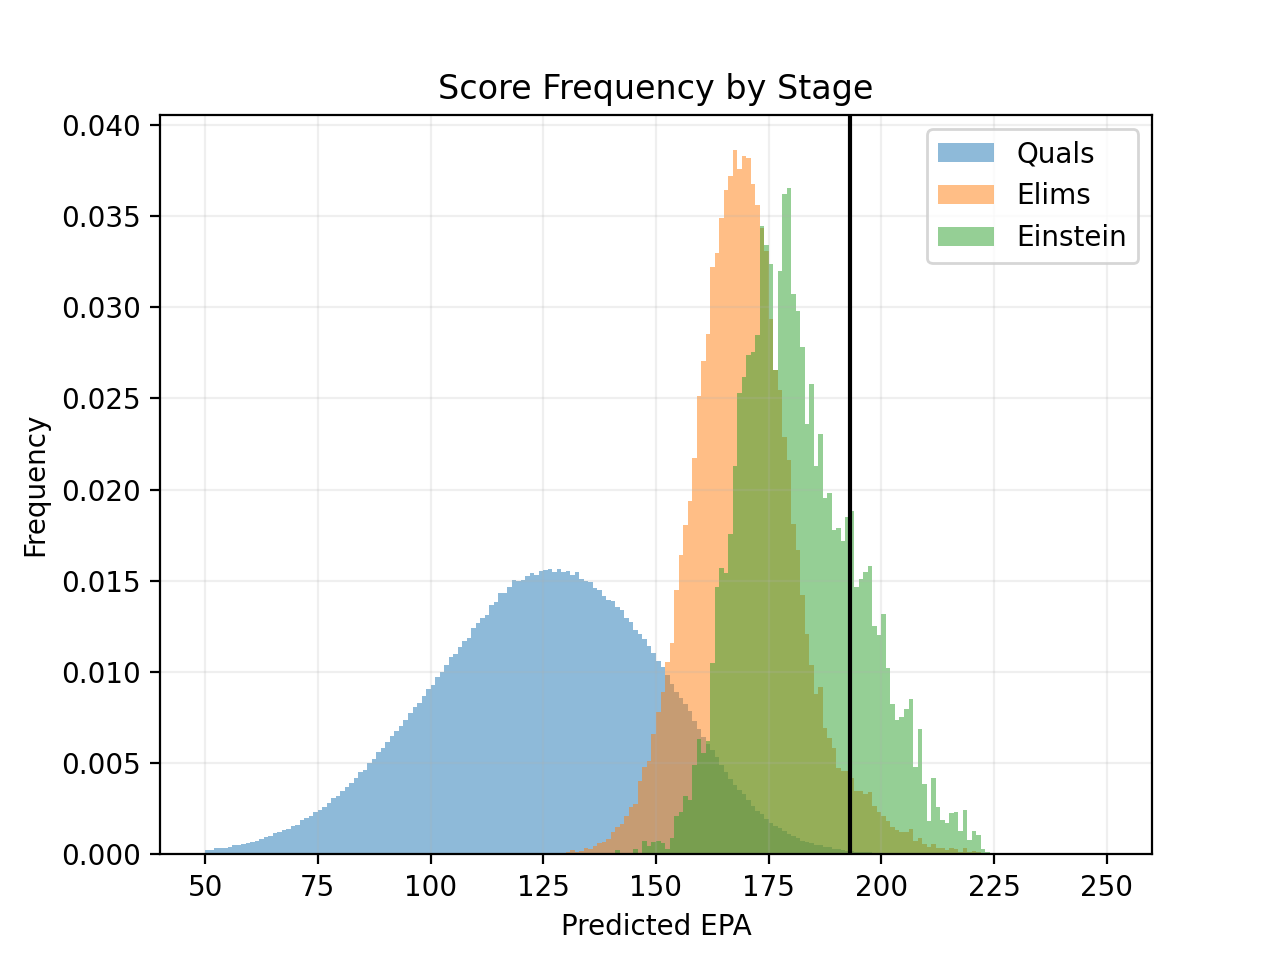

Quals
Greater than Seen 0.0027833011583011584
Greater than Max 0.0013581081081081082

Elims
Greater than Seen 0.04834134615384615
Greater than Max 0.03920673076923077

Einstein
Greater than Seen 0.2428076923076923
Greater than Max 0.20692307692307693



<IPython.core.display.Javascript object>


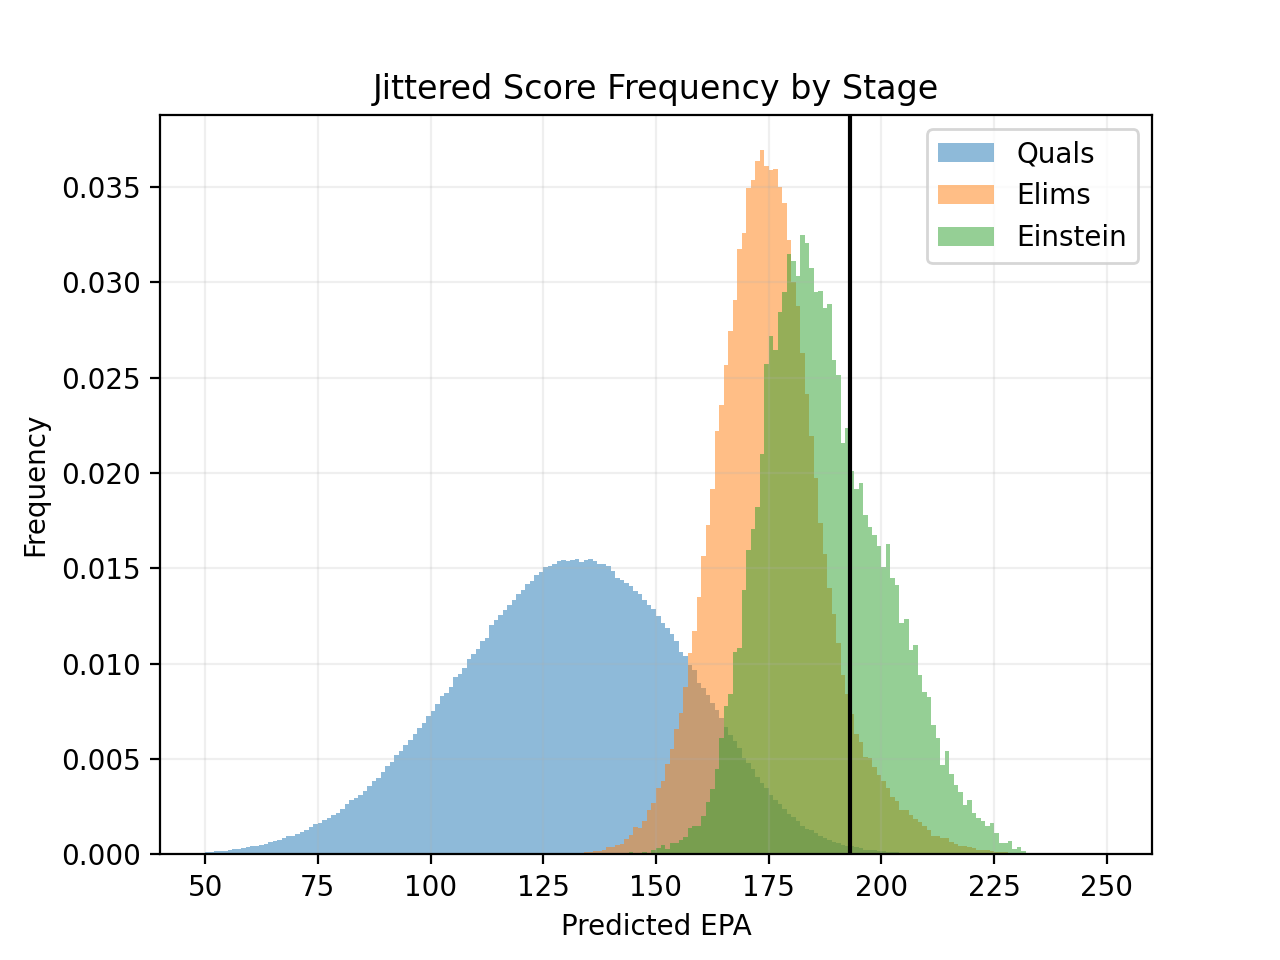

Quals
Greater than Seen 0.005464768339768339
Greater than Max 0.002796332046332046

Elims
Greater than Seen 0.08100961538461539
Greater than Max 0.06520673076923077

Einstein
Greater than Seen 0.33384615384615385
Greater than Max 0.29134615384615387



<IPython.core.display.Javascript object>


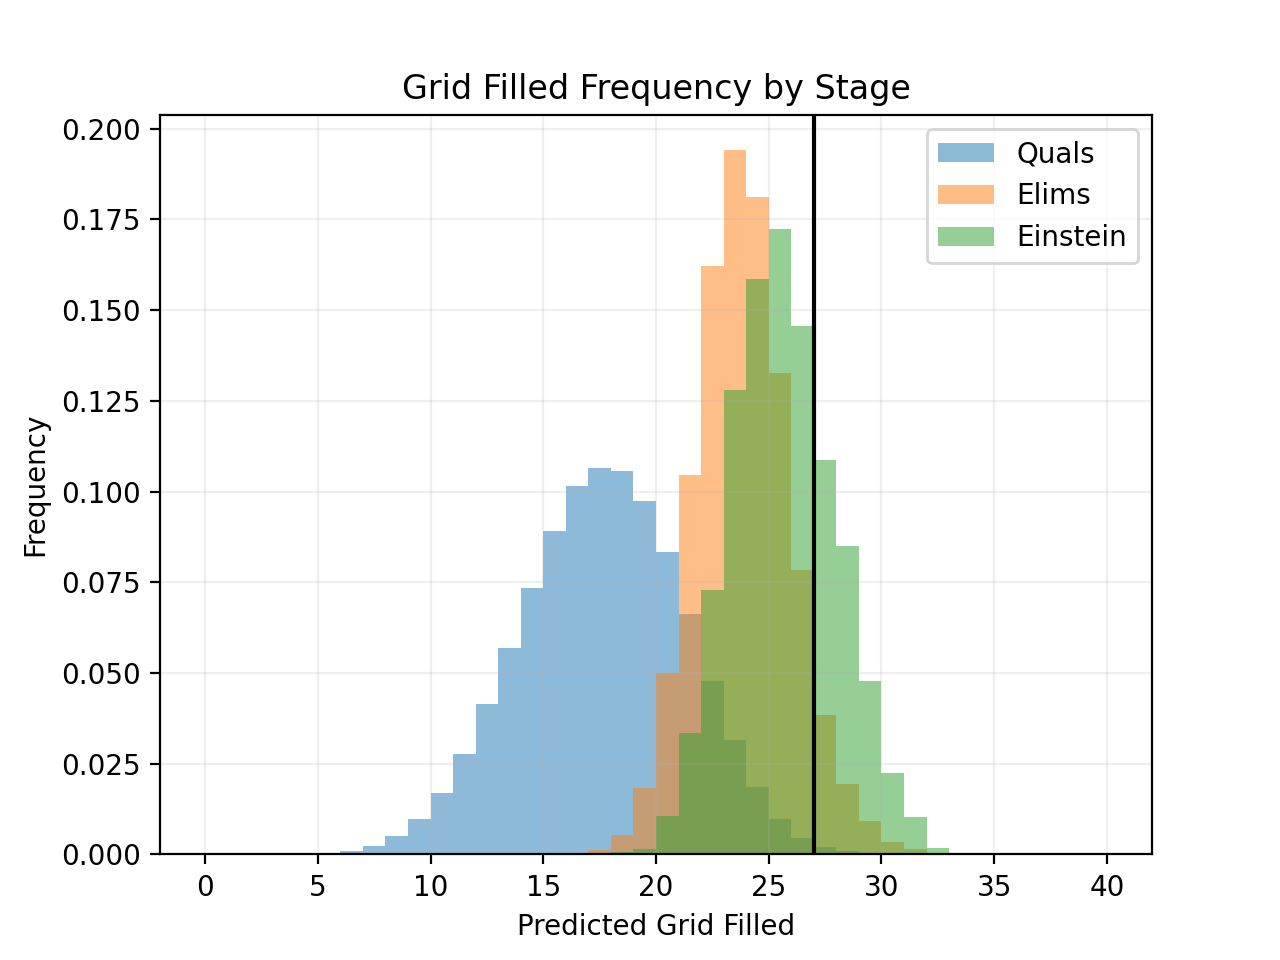

0.0032606177606177606
0.07224038461538461
0.2761923076923077


<IPython.core.display.Javascript object>


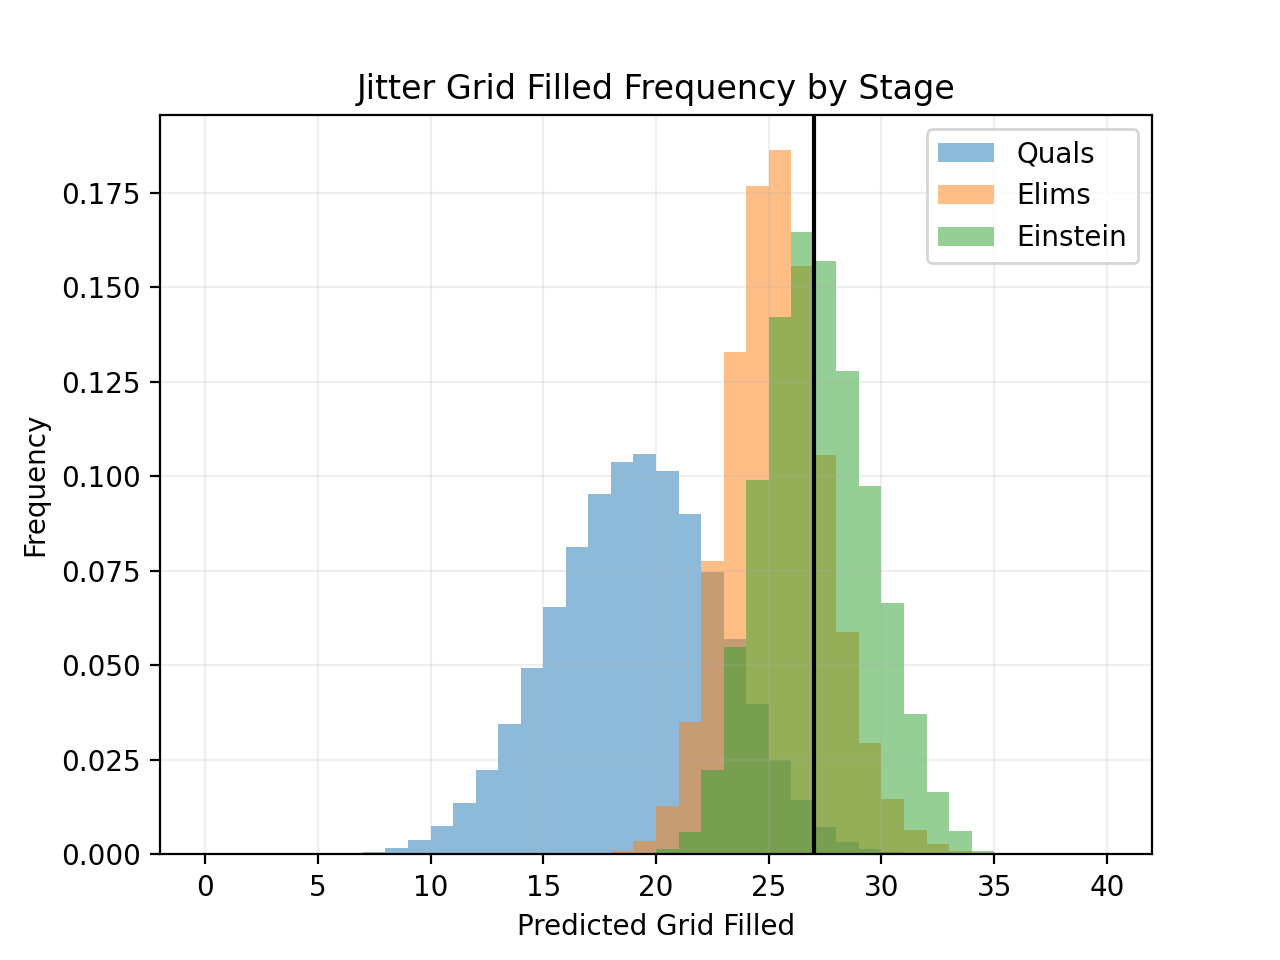

0.0056925675675675675
0.11304807692307692
0.3525


In [456]:
fig, ax = plt.subplots()
xrange = (50, 250)
bins = xrange[1] - xrange[0]
ax.hist(quals_score_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Quals")
ax.hist(elims_score_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Elims")
ax.hist(einstein_score_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Einstein")
ax.axvline(193, color="black")
ax.set_xlabel("Predicted EPA")
ax.set_ylabel("Frequency")
ax.set_title("Score Frequency by Stage")
ax.grid(alpha=0.2)
ax.legend()
fig.show()

print("Quals")
print("Greater than Seen", (np.array(quals_score_distrib) > 188).mean())
print("Greater than Max", (np.array(quals_score_distrib) > 193).mean())
print()

print("Elims")
print("Greater than Seen", (np.array(elims_score_distrib) > 191).mean())
print("Greater than Max", (np.array(elims_score_distrib) > 193).mean())
print()

print("Einstein")
print("Greater than Seen", (np.array(einstein_score_distrib) > 191).mean())
print("Greater than Max", (np.array(einstein_score_distrib) > 193).mean())
print()

fig, ax = plt.subplots()
xrange = (50, 250)
bins = xrange[1] - xrange[0]
jitter_quals_score_distrib = [round(x + 10 * random.random()) for x in quals_score_distrib]
jitter_elims_score_distrib = [round(x + 10 * random.random()) for x in elims_score_distrib]
jitter_einstein_score_distrib = [round(x + 10 * random.random()) for x in einstein_score_distrib]
ax.hist(jitter_quals_score_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Quals")
ax.hist(jitter_elims_score_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Elims")
ax.hist(jitter_einstein_score_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Einstein")
ax.axvline(193, color="black")
ax.set_xlabel("Predicted EPA")
ax.set_ylabel("Frequency")
ax.set_title("Jittered Score Frequency by Stage")
ax.grid(alpha=0.2)
ax.legend()
fig.show()

print("Quals")
print("Greater than Seen", (np.array(jitter_quals_score_distrib) > 188).mean())
print("Greater than Max", (np.array(jitter_quals_score_distrib) > 193).mean())
print()

print("Elims")
print("Greater than Seen", (np.array(jitter_elims_score_distrib) > 191).mean())
print("Greater than Max", (np.array(jitter_elims_score_distrib) > 193).mean())
print()

print("Einstein")
print("Greater than Seen", (np.array(jitter_einstein_score_distrib) > 191).mean())
print("Greater than Max", (np.array(jitter_einstein_score_distrib) > 193).mean())
print()

fig, ax = plt.subplots()
xrange = (0, 40)
bins = (xrange[1] - xrange[0])
ax.hist(quals_grid_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Quals")
ax.hist(elims_grid_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Elims")
ax.hist(einstein_grid_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Einstein")
ax.axvline(27, color="black")
ax.set_xlabel("Predicted Grid Filled")
ax.set_ylabel("Frequency")
ax.set_title("Grid Filled Frequency by Stage")
ax.grid(alpha=0.2)
ax.legend()
fig.show()

print((np.array(quals_grid_distrib) > 27).mean())
print((np.array(elims_grid_distrib) > 27).mean())
print((np.array(einstein_grid_distrib) > 27).mean())

fig, ax = plt.subplots()
xrange = (0, 40)
bins = (xrange[1] - xrange[0])
jitter_quals_grid_distrib = [round(x + 2 * random.random()) for x in quals_grid_distrib]
jitter_elims_grid_distrib = [round(x + 2 * random.random()) for x in elims_grid_distrib]
jitter_einstein_grid_distrib = [round(x + 2 * random.random()) for x in einstein_grid_distrib]
ax.hist(jitter_quals_grid_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Quals")
ax.hist(jitter_elims_grid_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Elims")
ax.hist(jitter_einstein_grid_distrib, alpha=0.5, range=xrange, bins=bins, density=True, label="Einstein")
ax.axvline(27, color="black")
ax.set_xlabel("Predicted Grid Filled")
ax.set_ylabel("Frequency")
ax.set_title("Jitter Grid Filled Frequency by Stage")
ax.grid(alpha=0.2)
ax.legend()
fig.show()

print((np.array(jitter_quals_grid_distrib) > 27).mean())
print((np.array(jitter_elims_grid_distrib) > 27).mean())
print((np.array(jitter_einstein_grid_distrib) > 27).mean())